In [1]:
#This header file contains all the common packages
%run /home/cz136/project/sa/lib/header.ipynb
phi_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
phi_w_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
e_list=np.load("/home/cz136/project/sa/data/e_array.npy")

In [2]:
print(len(clusters))
print(len(shapes))

16891
800332


In [3]:
def drop_poor_centers():
    """Drop clusters with no center shape data from the cluster dataframe"""
    center_id=clusters[('Alt', 'Alt1', 'ID_CENT')]
    pp=shapes.loc[center_id][('All','PP')].to_numpy()
    missing_mem_match_id=clusters[np.isnan(pp)].index
    clusters.drop(missing_mem_match_id,inplace=True)
    np.save("/home/cz136/project/sa/data/missing_centers.npy",center_id[np.isnan(pp)].to_numpy())
    print("The number of clusters with no center shape data {}".format(np.sum(np.isnan(pp))))
    print("The number of clusters with low probability center {}".format(np.sum(pp[~np.isnan(pp)]<=0.55)))
drop_poor_centers()

The number of clusters with no center shape data 0
The number of clusters with low probability center 19


In [4]:
# Print the numbers of galaxies that needed to be masked


print(np.sum(shapes[('All','e1')]==-9999))
print(np.sum(shapes[('All','e2')]==-9999))
print(np.sum(shapes['All','flags_select']==0))
print(np.sum(shapes[('All','PP')]<=0.55))

31700
31700
495540
357684


In [5]:
#masking


shapes=shapes[shapes[('All','PP')]>=0.55]
# shapes=shapes[shapes[('All','e1')]!=-9999]
# shapes=shapes[shapes[('All','e2')]!=-9999]
shapes=shapes[shapes[('All', 'flags_select')]==0]


print(len(clusters))
print(len(shapes))

16891
282735


# Stats of e1,e2

count    282735.000000
mean         -0.000116
std           0.148675
min          -0.728444
25%          -0.080703
50%          -0.000129
75%           0.080265
max           0.852003
Name: (All, e2), dtype: float64

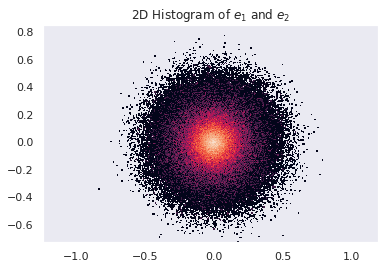

In [6]:
from matplotlib.colors import LogNorm 
plt.hist2d(shapes['All','e1'],shapes['All','e2'],bins=500,norm=LogNorm())
plt.axis('equal')
plt.title("2D Histogram of $e_1$ and $e_2$")
pd.Series(shapes['All','e1']).describe()
pd.Series(shapes['All','e2']).describe()

count    2.827350e+05
mean     5.531753e+00
std      2.784858e+03
min     -9.080580e+04
25%     -1.012196e+00
50%     -5.355862e-04
75%      1.003035e+00
max      1.471856e+06
dtype: float64

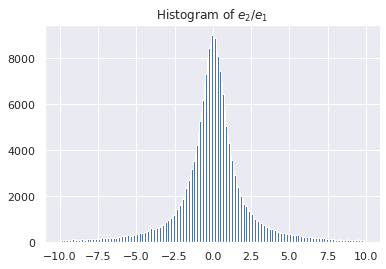

In [7]:
#statistics and hisgoram of e2/e1
plt.hist(shapes['All','e2']/shapes['All','e1'],bins=np.arange(-10,10,0.1))
plt.title("Histogram of $e_2$/$e_1$")
pd.Series(shapes['All','e2']/shapes['All','e1']).describe()

# Get phi 

In [8]:
def get_std_err_of_mean(np_array):
    mean=np_array.mean()
    std=np_array.std()
    n=len(np_array)
    return(std/np.sqrt(n))

In [9]:
def get_theta_for_obj(obj1,obj2):
    
    """Theta is the position angle of obj2 from north of east of obj1 """
    
    ra1,dec1=(obj1[('All', 'RA')],obj1[('All', 'DEC')])
    ra2,dec2=(obj2[('All', 'RA')],obj2[('All', 'DEC')])
    
    
    
    c1=SkyCoord(ra1*u.deg,dec1*u.deg)
    c2=SkyCoord(ra2*u.deg,dec2*u.deg)
    
    
    return(90-c1.position_angle(c2).degree)
    

In [10]:
def get_pa_for_obj(obj):
    e1=obj['All']['e1']
    e2=obj['All']['e1']
    
    α =0.5*np.arctan2(-e2,-e1)*180/np.pi
    return(α)

In [11]:
error_list_phi=[]
error_list_e=[]

def get_phi_for_cluster(cluster):
    
    """Input: cluster series
        Output: an array of position angle weighted by PP
        Record KeyError in an array (usually caused by uncomplete shape catalog).
    """
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]



        pa=np.array([get_pa_for_obj(member[1]) for member in members.iterrows()]).flatten()
        theta= np.array([get_theta_for_obj(member[1],center) for member in members.iterrows()]).flatten()
        pp=members[('All','PP')]
        phi=(pa-theta)
        phi_w=(pa-theta)*pp
    #     print(center.index)
        return(phi,phi_w)    
    except KeyError as e:
        error_list_phi.append(e)
        return(np.array([]),np.array([]))

In [12]:
phi_list=[]
phi_w_list=[]
for mem_matching_id in tqdm(clusters.index):
    phi_array=get_phi_for_cluster(clusters.loc[mem_matching_id])[0]
    phi_w_array=get_phi_for_cluster(clusters.loc[mem_matching_id])[1]
    phi_w_list.append(phi_w_array)
    phi_list.append(phi_array)
phi_list=np.array(phi_list)
phi_w_list=np.array(phi_w_list)

In [13]:
def process_phi(phi_list):

    phi_1d=np.concatenate(phi_list)

    phi_1d=np.where(phi_1d<=0,-phi_1d,phi_1d)
    phi_1d=np.where(phi_1d>=180,phi_1d-180,phi_1d)
    phi_1d=np.where(phi_1d>=90,180-phi_1d,phi_1d)

    phi_1d=np.sort(phi_1d)
    
    return(phi_1d)

phi_1d=process_phi(phi_list)
phi_w_1d=process_phi(phi_w_list)

In [14]:
np.save("/home/cz136/project/sa/data/phi_1d.npy",phi_1d)
np.save("/home/cz136/project/sa/data/phi_w_1d.npy",phi_w_1d)

## Stats for unweighted 

In [15]:
# phi_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
pd.Series(phi_1d).describe()
print("Mean:{:05e} \nStdE:{:05e} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

Mean:4.524481e+01 
StdE:5.718146e-02 


count    203080.000000
mean         45.244814
std          25.768544
min           0.000277
25%          22.500000
50%          45.390314
75%          67.500000
max          89.999729
dtype: float64

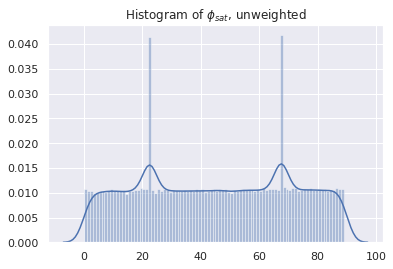

In [16]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $\phi_{sat}$, unweighted") 
pd.Series(phi_1d).describe()

## Stats for weighted

In [17]:
pd.Series(phi_w_1d).describe()
print("Mean:{:05e} \nStdE:{:05e} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

Mean:4.524481e+01 
StdE:5.718146e-02 


count    203080.000000
mean         45.102047
std          25.728301
min           0.000228
25%          22.500000
50%          44.983953
75%          67.500000
max          89.999829
dtype: float64

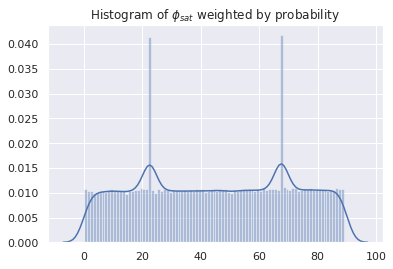

In [18]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $\phi_{sat}$ weighted by probability") 
pd.Series(phi_w_1d).describe()

# Analysis around 22.5 and 67.5

In [19]:
#Print out the most crowded bins

phi_count=np.histogram(phi_1d,bins=BINS)
sort=np.argsort(-phi_count[0])
print(phi_count[1][sort])
print(phi_count[0][sort])

[67 22 68 77 71 72 19 61 86 64 46 27 87 56 44 75  9 76 48 65 21 88 59 54
 38 82 80 69  0 20 63 40 25 43 66 36 70 84 53 23 85 51 28 47 81 18 30 55
 79 62 31 17 57 78 74 32 39 13 34 15  8 16 58 60 10  1  5 11 52  2 12 26
 33 42 35 37 83 73 45  6  7 29 49 41 50  4 24  3 14]
[8399 8329 2229 2207 2191 2190 2189 2186 2184 2181 2179 2177 2173 2171
 2170 2170 2169 2160 2160 2158 2157 2157 2156 2155 2154 2154 2153 2152
 2148 2148 2147 2145 2143 2140 2139 2137 2136 2134 2134 2133 2132 2129
 2126 2126 2124 2124 2124 2121 2120 2118 2116 2114 2112 2107 2107 2105
 2103 2102 2101 2100 2100 2096 2096 2095 2091 2089 2089 2083 2083 2081
 2079 2077 2075 2074 2071 2069 2069 2069 2068 2067 2056 2034 2022 2020
 2017 2014 2009 2009 1973]


count    8399.000000
mean       22.504317
std         0.150818
min        22.001008
25%        22.500000
50%        22.500000
75%        22.500000
max        23.030761
dtype: float64

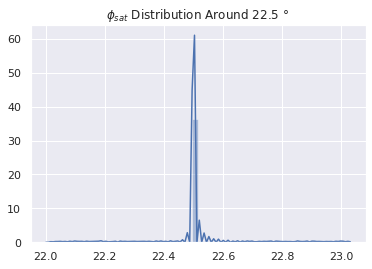

In [20]:
#Statistics around 22.5
first_cluster_left=np.sum(phi_count[0][0:22])
first_length=phi_count[0][sort][0]
first_cluster=phi_1d[first_cluster_left:first_cluster_left+first_length]
ax = sns.distplot(first_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 22.5 $\degree$")
pd.Series(first_cluster).describe()

count    8399.000000
mean       67.499718
std         0.145459
min        67.000531
25%        67.500000
50%        67.500000
75%        67.500000
max        67.999551
dtype: float64

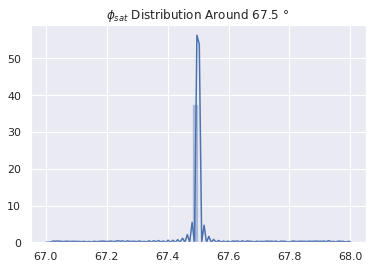

In [21]:
second_cluster_left=np.sum(phi_count[0][0:67])
second_length=phi_count[0][sort][0]
second_cluster=phi_1d[second_cluster_left:second_cluster_left+second_length]
ax = sns.distplot(second_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 67.5 $\degree$")
pd.Series(second_cluster).describe()

# Get e

## Statistics of e1 and e2

In [22]:
e1=shapes[('All','e1')].to_numpy()
shapes[('All','e1')].describe()

count    282735.000000
mean          0.000207
std           0.147948
min          -0.838272
25%          -0.079423
50%          -0.000208
75%           0.079905
max           0.789564
Name: (All, e1), dtype: float64

In [23]:
e2=shapes[('All','e1')].to_numpy()
shapes[('All','e2')].describe()

count    282735.000000
mean         -0.000116
std           0.148675
min          -0.728444
25%          -0.080703
50%          -0.000129
75%           0.080265
max           0.852003
Name: (All, e2), dtype: float64

In [24]:
def get_e_for_pair(cen,sat):
    e=np.sqrt(sat[('All','e1')]**2+sat[('All','e2')]**2)
    delta=get_theta_for_obj(cen,sat)
    alpha=get_pa_for_obj(sat)
    ep,ex=(e*np.cos(2*(delta-alpha)),e*np.sin(2*(delta-alpha)))
    return(ep,ex)

In [25]:
def get_e_for_cluster(cluster):
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]

        e_array=np.array([(get_e_for_pair(center,member[1])) for member in members.iterrows()])
        return(e_array)    
    except KeyError as e:
        error_list_e.append(e)
        return(np.array([]))

In [26]:
e_list=[]
for mem_matching_id in tqdm(clusters.index[:]):
    e_array=get_e_for_cluster(clusters.loc[mem_matching_id])
    e_list.append(e_array)
e_list=np.array(e_list)
e_list=np.concatenate([e_array for e_array in e_list if e_array!=np.array([])])

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [27]:
np.save("/home/cz136/project/sa/data/e_array",e_list)

In [28]:
e_p_1d=e_list[:,0].flatten()
e_x_1d=e_list[:,1].flatten()

mean=-1.078339e-03, std_mean=3.298987e-04


count    203080.000000
mean         -0.001078
std           0.148667
min          -0.707431
25%          -0.084115
50%          -0.000076
75%           0.080770
max           0.790708
dtype: float64

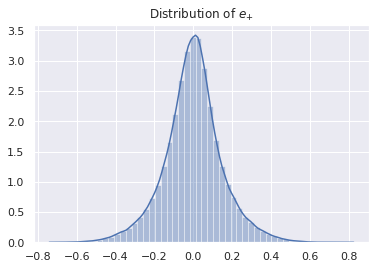

In [29]:
ax=sns.distplot(e_p_1d)
ax.set_title("Distribution of $e_{+}$")
print ("mean={:05e}, std_mean={:05e}".format(e_p_1d.mean(),get_std_err_of_mean(e_p_1d)))
pd.Series(e_p_1d).describe()

mean=2.527025e-03, std_mean=3.249719e-04


count    203080.000000
mean          0.002527
std           0.146447
min          -0.750668
25%          -0.075569
50%           0.006091
75%           0.080926
max           0.786804
dtype: float64

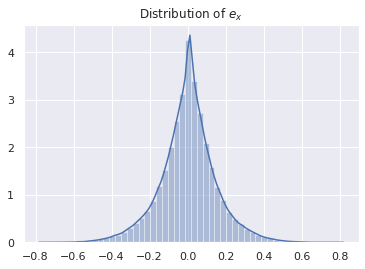

In [30]:
ax=sns.distplot(e_x_1d)
ax.set_title("Distribution of $e_{x}$")
print ("mean={:05e}, std_mean={:05e}".format(e_x_1d.mean(),get_std_err_of_mean(e_x_1d)))
pd.Series(e_x_1d).describe()

# Analysis

It seems the only things unexpected are the features around 22.5 and 67.5 degrees and the non-zero mean of ex.